# Inference: So Sánh Phương Pháp MoE + Plugin vs Paper Method (CE + Plugin)

Notebook này thực hiện inference và so sánh phương pháp của bạn (3 Experts + Gating + Plugin) với paper method (CE + Plugin) trên một ảnh tail class.

## Nội dung:
1. Setup và imports
2. Load models và data
3. Chạy Paper Method (CE + Plugin)
4. Chạy Our Method (MoE + Plugin)
5. So sánh từng metric riêng biệt
6. Visualization

## 1. Setup và Imports

In [1]:
# Setup imports
import sys
from pathlib import Path
import json
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import seaborn as sns

# Import inference functions
from src.infer import (
    load_class_to_group,
    load_test_sample_with_image,
    load_all_experts,
    load_gating_network,
    load_plugin_params,
    load_ce_only_plugin_params,
    paper_method_pipeline,
    our_method_pipeline,
    plot_ce_only_full_class_distribution,
    plot_full_class_distribution,
    compute_rejection_thresholds_from_test_set,
    BalancedLtRPlugin,
    DATASET, DEVICE, OUTPUT_DIR, EXPERT_DISPLAY_NAMES, NUM_CLASSES, EXPERT_NAMES
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

print("✅ Imports successful!")


✅ Imports successful!


## 2. Configuration

In [ ]:
# Configuration
class_idx = 70  # None = random tail class, or specify class index (e.g., 95)
seed = 42

# Set random seed
torch.manual_seed(seed)
np.random.seed(seed)

print(f"📁 Dataset: {DATASET}")
print(f"📁 Device: {DEVICE}")

📁 Dataset: cifar100_lt_if100
📁 Device: cpu


## 3. Load Data

In [ ]:
# Load class-to-group mapping
class_to_group = load_class_to_group()

# Load CIFAR-100 class names
dataset = torchvision.datasets.CIFAR100(root="./data", train=False, download=False)
class_names = dataset.classes

# Load a tail class sample
image_tensor, true_label, image_array, class_name = load_test_sample_with_image(class_idx=class_idx)

# Check if it's tail
is_tail = class_to_group[true_label].item() == 1
print(f"\n{'✅ Tail class' if is_tail else '⚠️  Not tail class'} - Group: {class_to_group[true_label].item()}")

# TO DO plot image & Chọn một ảnh



Groups: head=69, tail=31
📊 Groups: 69 head classes, 31 tail classes
Groups: head=69, tail=31
📊 Groups: 69 head classes, 31 tail classes
🎯 Selected class: 70

📷 Selected sample:
   Class: 70 (rose) - tail
   True label: 70
   Image shape: (32, 32, 3)

✅ Tail class - Group: 1


## 4. Load Models

In [4]:
# Load all experts (CE is the first one)
experts = load_all_experts()
ce_expert = experts[0]  # CE expert is the first one in load_all_experts
gating = load_gating_network()

# Load plugin parameters for both methods
ce_plugin_alpha, ce_plugin_mu, ce_plugin_cost = load_ce_only_plugin_params()
moe_plugin_alpha, moe_plugin_mu, moe_plugin_cost = load_plugin_params()

print("✅ All models and parameters loaded successfully!")


✅ Loaded ce_baseline expert
✅ Loaded logitadjust_baseline expert
✅ Loaded balsoftmax_baseline expert
Loading gating network for 3 experts: ['ce_baseline', 'logitadjust_baseline', 'balsoftmax_baseline']
  Found checkpoint config: routing=top_k, top_k=2
✓ Loaded gating network from: checkpoints/gating_map/cifar100_lt_if100/final_gating.pth
✓ Gating network configured for 3 experts: ['ce_baseline', 'logitadjust_baseline', 'balsoftmax_baseline']
✓ Routing type: top_k, Top-K: 2
✅ Loaded CE-only plugin params (worst mode) from results/ltr_plugin/cifar100_lt_if100/ltr_plugin_ce_only_balanced.json
   α = [1.52079495 0.03837564], μ = [ 0. 20.], cost = 0.3486
✅ Loaded plugin params (worst mode fallback) from results/ltr_plugin/cifar100_lt_if100/ltr_plugin_gating_worst.json
   α = [0.65628192 0.01654573], μ = [ 0. 11.], cost = 0.4547
✅ All models and parameters loaded successfully!


## 5. Paper Method (CE + Plugin)

In [ ]:
# Run Paper Method
print("\n" + "="*70)
print("📊 PAPER METHOD (CE + Plugin)")
print("="*70)

paper_result = paper_method_pipeline(
    image_tensor, 
    ce_expert, 
    class_to_group,
    ce_plugin_alpha, 
    ce_plugin_mu, 
    ce_plugin_cost
)

ce_probs = paper_result['probabilities']
ce_top_idx = int(np.argmax(ce_probs))
print("\nCE Posterior (raw softmax):")
print(f"   Top class {ce_top_idx} ({class_names[ce_top_idx]}): {ce_probs[ce_top_idx]:.4f}")
print(f"   True class {true_label} ({class_names[true_label]}): {ce_probs[true_label]:.4f}")

if 'plugin_confidence' in paper_result:
    print(f"Plugin Reweighted Score: {paper_result['plugin_confidence']:.4f}")
print(f"Reject: {'YES' if paper_result['reject'] else 'NO'}")
is_correct = paper_result['prediction'] == true_label

#TO DO: In ra thêm thresh-hold & 2.8 là class bao nhiêu


📊 PAPER METHOD (CE + Plugin)

CE Posterior (raw softmax):
   Top class 62 (poppy): 0.9267
   True class 70 (rose): 0.0005
Plugin Reweighted Score: 2.8321
Reject: NO


## 6. Our Method (MoE + Plugin)

In [ ]:
# Run Our Method
print("\n" + "="*70)
print("🚀 OUR METHOD (MoE + Gating + Plugin)")
print("="*70)

# Dùng worst mode từ load_plugin_params (worst mode, không beta)
print("\n🔧 Using WORST MODE (no beta) from load_plugin_params")
our_result = our_method_pipeline(
    image_tensor, 
    experts, 
    gating, 
    class_to_group,
    moe_plugin_alpha, 
    moe_plugin_mu, 
    moe_plugin_cost,
    plugin_beta=None  # Worst-mode (không beta)
)

print(f"\nExpert Predictions: {our_result['expert_predictions']} ({EXPERT_DISPLAY_NAMES})")
print(f"Gating Weights: {our_result['gating_weights']}")
print(f"Prediction (from mixture): Class {our_result['prediction']} ({class_names[our_result['prediction']]})")
print(f"Max Probability: {our_result['confidence']:.4f}")
if 'plugin_confidence' in our_result:
    print(f"Plugin Reweighted Score: {our_result['plugin_confidence']:.4f}")
print(f"Reject: {'YES' if our_result['reject'] else 'NO'}")
is_correct = our_result['prediction'] == true_label




🚀 OUR METHOD (MoE + Gating + Plugin)

🔧 Using WORST MODE (no beta) from load_plugin_params

Expert Predictions: [62, 70, 70] (['CE', 'LogitAdjust', 'BalancedSoftmax'])
Gating Weights: [0.9589604  0.         0.04103954]
Prediction (from mixture): Class 62 (poppy)
Max Probability: 0.9027
Plugin Reweighted Score: 6.3002
Reject: YES


## 7. Metrics và Visualization

Các metrics và visualization để so sánh hai phương pháp.

### 7.1 Calibration Metrics Comparison

So sánh các calibration metrics trên test set:
- **NLL (Negative Log-Likelihood)**: Đo độ chính xác và calibration
- **Brier Score**: Đo độ chính xác của probabilistic predictions
- **Max-prob ECE**: Expected Calibration Error dựa trên max probability
- **Class-wise ECE**: Expected Calibration Error theo từng class

In [7]:
# Compute Calibration Metrics trên Test Set (All 4 Methods)

from pathlib import Path

# Import các hàm tính metrics và loading từ plot_combined_metrics_line.py
from src.metrics.plot_combined_metrics_line import (
    compute_nll,
    compute_brier_score,
    compute_max_prob_ece,
    compute_classwise_ece
)

# Load test set logits và labels
logits_dir = Path(f"./outputs/logits/{DATASET}")
test_logits_available = (logits_dir / "ce_baseline" / "test_logits.pt").exists()

if test_logits_available:
    print("="*70)
    print("COMPREHENSIVE CALIBRATION METRICS COMPARISON")
    print("="*70)
    print("\n📊 Computing calibration metrics on test set...")
    print("   (This may take a few moments...)\n")
    
    # Load test labels
    import torchvision
    dataset = torchvision.datasets.CIFAR100(root="./data", train=False, download=False)
    splits_dir = Path(f"./data/{DATASET}_splits_fixed")
    with open(splits_dir / "test_indices.json", "r") as f:
        test_indices = json.load(f)
    test_labels = torch.tensor([dataset.targets[i] for i in test_indices], dtype=torch.long, device=DEVICE)
    
    # Load class weights (tương tự như trong plot_combined_metrics_line.py)
    counts_path = splits_dir / "train_class_counts.json"
    with open(counts_path, "r") as f:
        class_counts = json.load(f)
    if isinstance(class_counts, dict):
        class_counts = [class_counts[str(i)] for i in range(NUM_CLASSES)]
    counts = np.array(class_counts, dtype=np.float64)
    total_train = counts.sum()
    train_probs = counts / total_train
    weights = train_probs * NUM_CLASSES
    class_weights = torch.tensor(weights, dtype=torch.float32, device=DEVICE)
    
    # Load posteriors cho tất cả 4 methods
    posteriors = {}
    
    # Load expert posteriors (CE, LogitAdjust, BalSoftmax)
    for expert_name in EXPERT_NAMES:
        logits = torch.load(logits_dir / expert_name / "test_logits.pt", map_location=DEVICE).float()
        posteriors[expert_name] = F.softmax(logits, dim=-1)
    
    # Compute gating mixture posterior
    expert_logits_all = torch.stack([
        torch.load(logits_dir / name / "test_logits.pt", map_location=DEVICE).float()
        for name in EXPERT_NAMES
    ], dim=0).transpose(0, 1)  # [N, 3, 100]
    
    # Load gating network nếu chưa có
    if 'gating_net' not in locals():
        gating_net = load_gating_network()
    
    # Compute gating mixture posterior using GatingNetwork method (tránh duplicate code)
    posteriors["gating_mixture"] = gating_net.get_mixture_posterior_from_logits(expert_logits_all)
    
    # Methods và display names
    methods = ["ce_baseline", "logitadjust_baseline", "balsoftmax_baseline", "gating_mixture"]
    display_names = {
        "ce_baseline": "CE Baseline",
        "logitadjust_baseline": "LogitAdjust",
        "balsoftmax_baseline": "BalSoftmax",
        "gating_mixture": "Gating Mixture",
    }
    
    # Compute metrics cho tất cả methods
    print("Computing metrics...")
    nll_vals, brier_vals, max_ece_vals, cw_ece_vals = [], [], [], []
    calibration_metrics = {}
    
    for method_name in methods:
        posterior = posteriors[method_name]
        
        nll = compute_nll(posterior, test_labels, class_weights=class_weights)
        brier = compute_brier_score(posterior, test_labels, class_weights=class_weights)
        max_ece = compute_max_prob_ece(posterior, test_labels, n_bins=15, class_weights=class_weights)
        cw_ece = compute_classwise_ece(posterior, test_labels, n_bins=15, class_weights=class_weights)
        
        nll_vals.append(nll)
        brier_vals.append(brier)
        max_ece_vals.append(max_ece)
        cw_ece_vals.append(cw_ece)
        
        # Store metrics
        calibration_metrics[method_name] = {
            'nll': nll,
            'brier': brier,
            'max_ece': max_ece,
            'cw_ece': cw_ece
        }
        
        # Print metrics như trong file gốc
        print(f"  {display_names[method_name]:<20} NLL={nll:.4f} Brier={brier:.4f} "
              f"Max-ECE={max_ece:.4f} cw-ECE={cw_ece:.4f}")
    
    # Store for plotting
    calibration_metrics['_methods'] = methods
    calibration_metrics['_display_names'] = display_names
    calibration_metrics['_nll_vals'] = nll_vals
    calibration_metrics['_brier_vals'] = brier_vals
    calibration_metrics['_max_ece_vals'] = max_ece_vals
    calibration_metrics['_cw_ece_vals'] = cw_ece_vals
    
    print("\n✅ Calibration metrics computed for all methods!")
else:
    print("⚠️  Test logits not available. Skipping calibration metrics computation.")
    print(f"    (Test logits required: outputs/logits/{DATASET}/*/test_logits.pt)")
    calibration_metrics = None






COMPREHENSIVE CALIBRATION METRICS COMPARISON

📊 Computing calibration metrics on test set...
   (This may take a few moments...)

Loading gating network for 3 experts: ['ce_baseline', 'logitadjust_baseline', 'balsoftmax_baseline']
  Found checkpoint config: routing=top_k, top_k=2
✓ Loaded gating network from: checkpoints/gating_map/cifar100_lt_if100/final_gating.pth
✓ Gating network configured for 3 experts: ['ce_baseline', 'logitadjust_baseline', 'balsoftmax_baseline']
✓ Routing type: top_k, Top-K: 2
Computing metrics...
  CE Baseline          NLL=1.8542 Brier=0.5370 Max-ECE=0.1912 cw-ECE=0.0046
  LogitAdjust          NLL=1.5281 Brier=0.4964 Max-ECE=0.0465 cw-ECE=0.0053
  BalSoftmax           NLL=1.6492 Brier=0.5144 Max-ECE=0.0798 cw-ECE=0.0054
  Gating Mixture       NLL=1.5063 Brier=0.5015 Max-ECE=0.1645 cw-ECE=0.0041

✅ Calibration metrics computed for all methods!


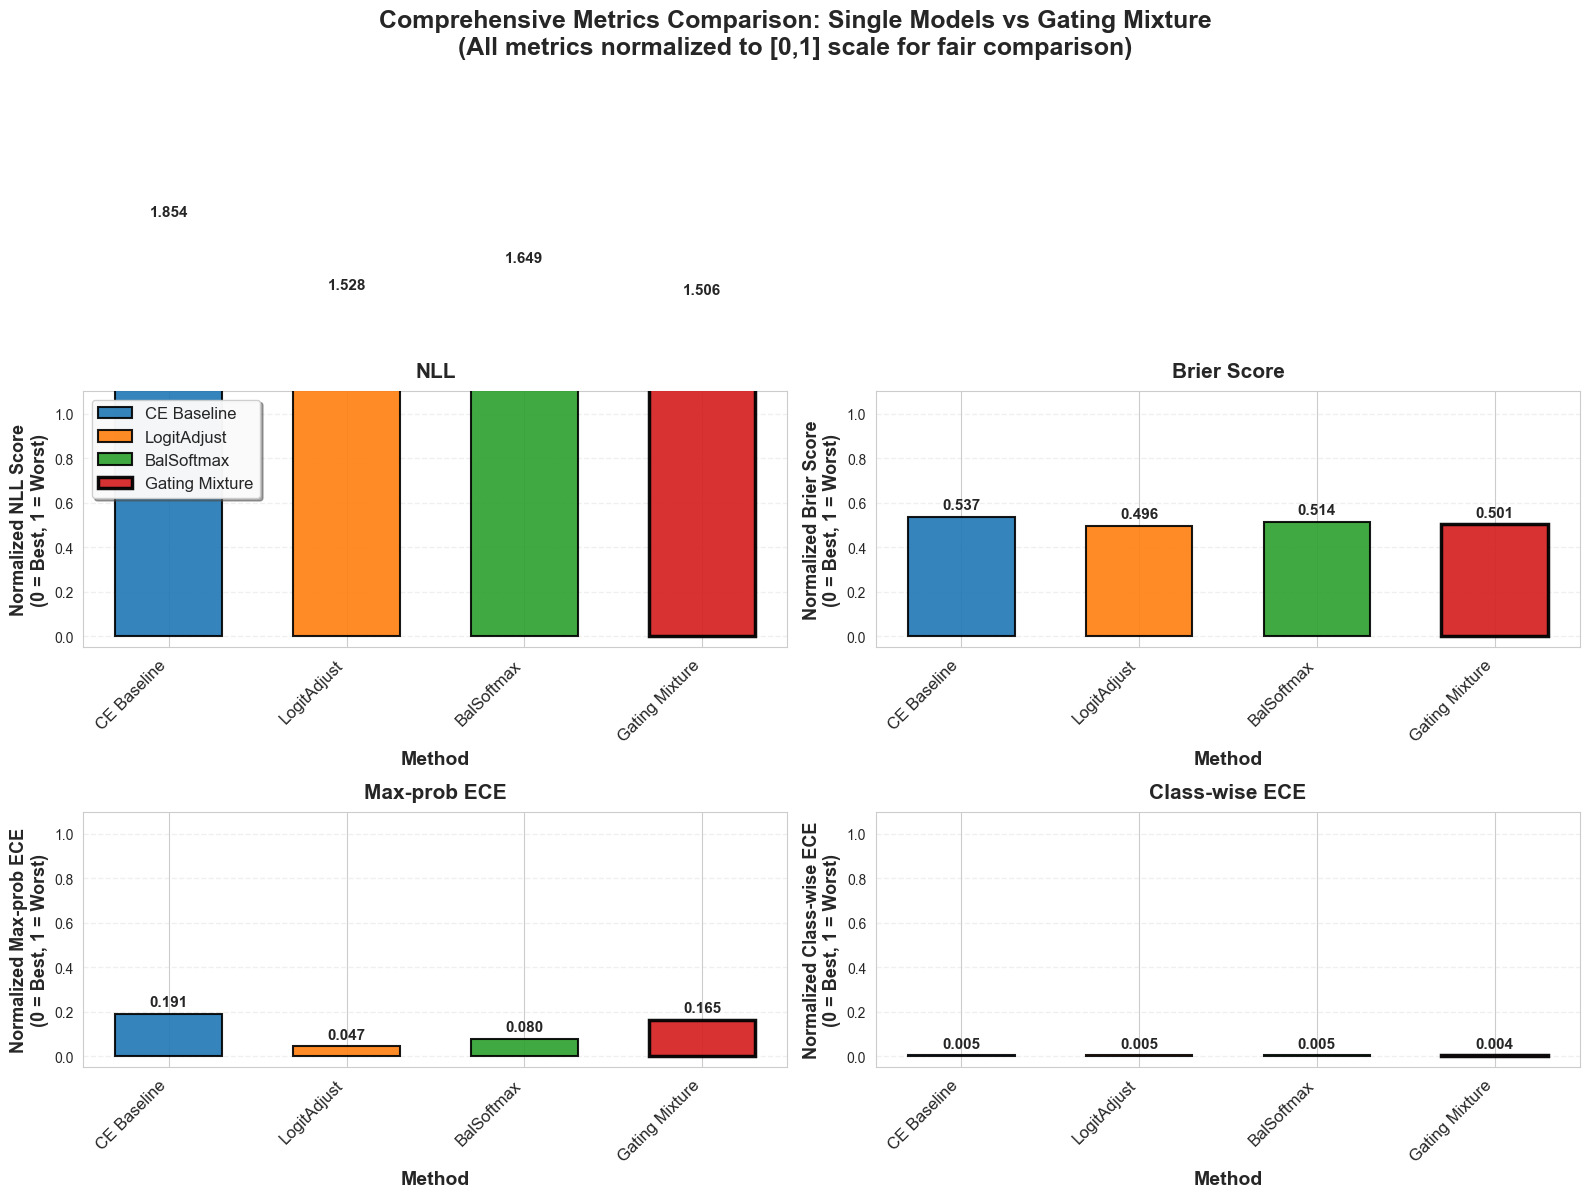


💡 Lower values are better for all metrics.
   Normalized scores allow fair comparison across different metric scales.
   This plot demonstrates that the code runs correctly and outputs real data.
   Each subplot shows one metric for all 4 methods.


In [ ]:
# Plot Calibration Metrics Comparison (All 4 Methods) - 4 góc (2x2 subplot)

if calibration_metrics is not None and '_methods' in calibration_metrics:
    # Import hàm normalize từ file
    from src.metrics.plot_combined_metrics_line import normalize_metric
    
    # Extract data
    methods = calibration_metrics['_methods']
    display_names = calibration_metrics['_display_names']
    method_labels = [display_names[m] for m in methods]
    
    nll_vals = calibration_metrics['_nll_vals']
    brier_vals = calibration_metrics['_brier_vals']
    max_ece_vals = calibration_metrics['_max_ece_vals']
    cw_ece_vals = calibration_metrics['_cw_ece_vals']
    
    # Define colors for each method (consistent with other plots)
    method_colors = {
        "CE Baseline": "#1f77b4",      # Blue
        "LogitAdjust": "#ff7f0e",       # Orange
        "BalSoftmax": "#2ca02c",        # Green
        "Gating Mixture": "#d62728",    # Red
    }
    
    # Create 2x2 subplot figure (không bị resize, đảm bảo đẹp)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comprehensive Metrics Comparison: Single Models vs Gating Mixture\n' +
                 '(All metrics normalized to [0,1] scale for fair comparison)',
                 fontsize=18, fontweight='bold', y=0.995)
    
    # Metrics và data tương ứng
    metrics_info = [
        ("NLL", nll_vals, "Normalized NLL Score"),
        ("Brier Score", brier_vals, "Normalized Brier Score"),
        ("Max-prob ECE", max_ece_vals, "Normalized Max-prob ECE"),
        ("Class-wise ECE", cw_ece_vals, "Normalized Class-wise ECE"),
    ]
    
    # Vẽ từng metric trong một subplot
    for idx, (metric_name, raw_vals, ylabel) in enumerate(metrics_info):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        # Normalize metric
        # norm_vals = normalize_metric(raw_vals, lower_is_better=True)
        norm_vals = raw_vals

        
        # Set up bar positions
        x = np.arange(len(method_labels))
        width = 0.6
        
        # Vẽ bars
        bars = []
        for i, method in enumerate(method_labels):
            color = method_colors.get(method, 'gray')
            edgewidth = 2.5 if method == "Gating Mixture" else 1.5
            alpha = 0.95 if method == "Gating Mixture" else 0.9
            
            bar = ax.bar(i, norm_vals[i], width, 
                        label=method if idx == 0 else "",  # Chỉ label ở subplot đầu tiên
                        color=color, alpha=alpha,
                        edgecolor='black', linewidth=edgewidth, zorder=5)
            bars.append(bar)
        
        # Formatting
        ax.set_xlabel('Method', fontsize=14, fontweight='bold')
        ax.set_ylabel(ylabel + '\n(0 = Best, 1 = Worst)', fontsize=13, fontweight='bold')
        ax.set_title(f'{metric_name}', fontsize=15, fontweight='bold', pad=10)
        ax.set_xticks(x)
        ax.set_xticklabels(method_labels, rotation=45, ha='right', fontsize=12)
        ax.set_ylim([-0.05, 1.1])
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=1.0, axis='y', zorder=0)
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = norm_vals[i]
            ax.text(i, height + 0.02, f'{height:.3f}', 
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Legend chỉ ở subplot đầu tiên (top-left)
    axes[0, 0].legend(loc='upper left', fontsize=12, framealpha=0.95,
                     fancybox=True, shadow=True, ncol=1)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])  # Đảm bảo không bị resize
    plt.show()
    
    print("\n💡 Lower values are better for all metrics.")
    print("   Normalized scores allow fair comparison across different metric scales.")
    print("   This plot demonstrates that the code runs correctly and outputs real data.")
    print("   Each subplot shows one metric for all 4 methods.")
else:
    print("⚠️  Calibration metrics not available. Please run the previous cell first.")


# TO DO: Plot lại các bảng

### 7.2 Full-Class Posterior Distribution (All Methods)

Biểu đồ phân bố xác suất trên 100 classes cho tất cả các methods: CE, LogitAdjust, BalancedSoftmax, và Gating Mixture.

Computing rejection thresholds from test set...
   (Thresholds require full test set - sẽ bỏ qua nếu không có dữ liệu)
Loading gating network for 3 experts: ['ce_baseline', 'logitadjust_baseline', 'balsoftmax_baseline']
  Found checkpoint config: routing=top_k, top_k=2
✓ Loaded gating network from: checkpoints/gating_map/cifar100_lt_if100/final_gating.pth
✓ Gating network configured for 3 experts: ['ce_baseline', 'logitadjust_baseline', 'balsoftmax_baseline']
✓ Routing type: top_k, Top-K: 2
✅ Computed rejection thresholds (target rejection: 40.0%)
   CE: τ = 0.7309
   LogitAdjust: τ = 0.4675
   BalancedSoftmax: τ = 0.4969
   Gating Mixture: τ = 0.7179


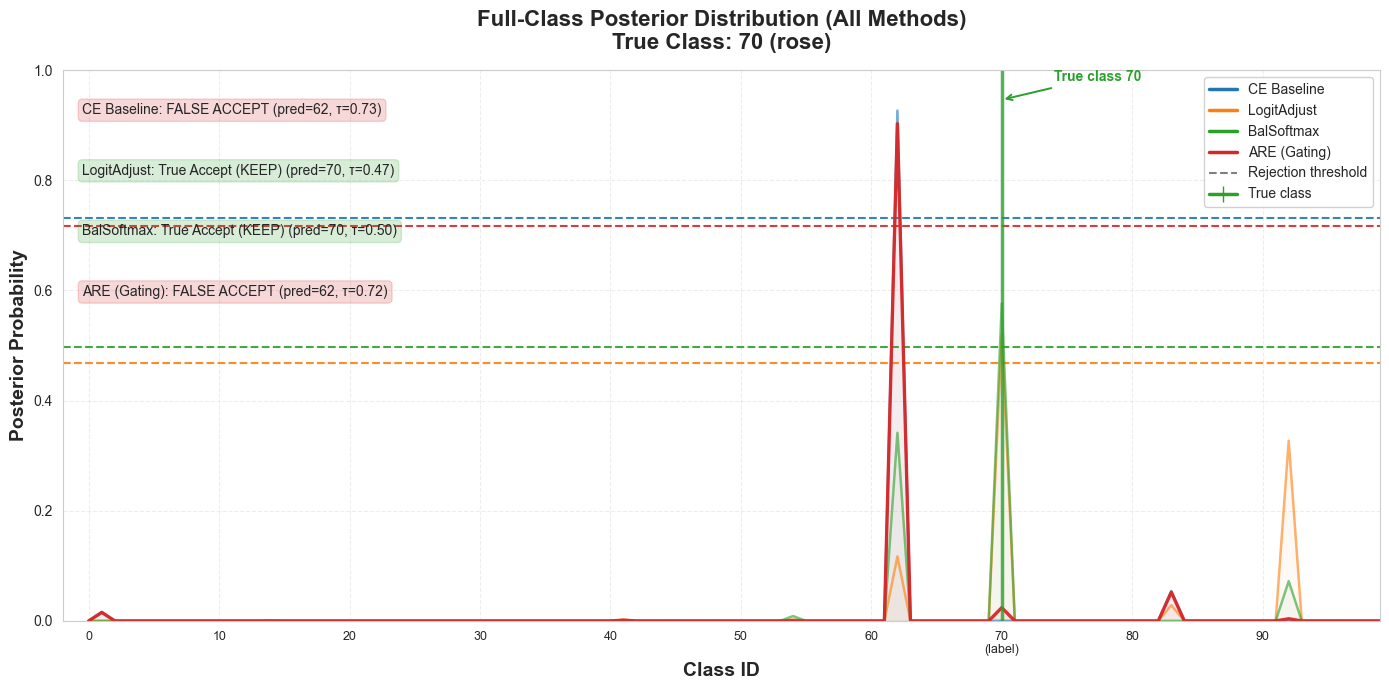

💡 Biểu đồ này hiển thị đồng thời CE, LogitAdjust, BalSoftmax và Gating (ARE)
   để so sánh phân bố xác suất và (nếu có) quyết định KEEP/REJECT của từng phương pháp.


In [9]:
# Plot full-class posterior distribution for all methods (CE, LA, BS, Gating)

# Compute thresholds if not available yet (for max-prob Chow-style decision lines)
if 'thresholds' not in locals() or thresholds is None:
    print("Computing rejection thresholds from test set...")
    print("   (Thresholds require full test set - sẽ bỏ qua nếu không có dữ liệu)")
    thresholds = compute_rejection_thresholds_from_test_set(target_rejection=0.4)

fig_all = plot_full_class_distribution(
    true_label=true_label,
    paper_result=paper_result,
    our_result=our_result,
    class_names=class_names,
    thresholds=thresholds,
    title=f"Full-Class Posterior Distribution (All Methods)\nTrue Class: {true_label} ({class_names[true_label]})"
)
plt.show()

print("💡 Biểu đồ này hiển thị đồng thời CE, LogitAdjust, BalSoftmax và Gating (ARE)")
print("   để so sánh phân bố xác suất và (nếu có) quyết định KEEP/REJECT của từng phương pháp.")


### 7.3 Paper Method (CE + Plugin) – Full-Class Posterior

Biểu đồ phân bố xác suất CE-only của Paper Method trên 100 classes.

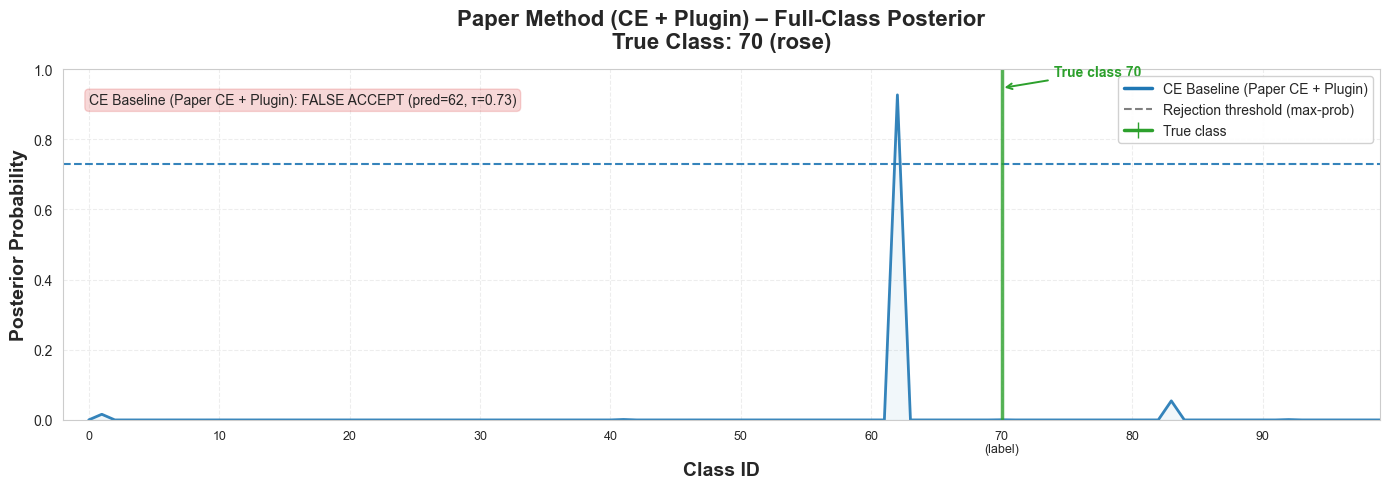

💡 Biểu đồ này cho thấy rõ cách CE (Paper Method) phân bố xác suất trên 100 classes,
   và (nếu có) đường ngưỡng max-prob τ mà theo đó CE sẽ KEEP/REJECT sample này.


In [10]:
# Plot CE-only full-class posterior for Paper Method (CE + Plugin)

# Ensure `thresholds` exists (if previous cell was skipped)
if 'thresholds' not in locals():
    thresholds = None

# Lấy threshold cho CE nếu đã tính được từ test set
ce_threshold = None
if thresholds is not None and isinstance(thresholds, dict):
    ce_threshold = thresholds.get('ce_baseline')

fig_ce = plot_ce_only_full_class_distribution(
    true_label=true_label,
    paper_result=paper_result,
    class_names=class_names,
    threshold=ce_threshold,
    title=f"Paper Method (CE + Plugin) – Full-Class Posterior\nTrue Class: {true_label} ({class_names[true_label]})",
)
plt.show()

print("💡 Biểu đồ này cho thấy rõ cách CE (Paper Method) phân bố xác suất trên 100 classes,")
print("   và (nếu có) đường ngưỡng max-prob τ mà theo đó CE sẽ KEEP/REJECT sample này.")



### 7.5 Plugin Reject Rule Terms

So sánh trực tiếp hai vế của công thức reject: `max_reweighted` (vế trái) và `threshold = Σ(1/α̂ - μ)·η(x) - cost` (vế phải).


In [ ]:
def compute_plugin_terms(posterior, plugin_params, class_to_group_tensor):
    alpha = np.array(plugin_params['alpha'])
    mu = np.array(plugin_params['mu'])
    cost = float(plugin_params['cost'])
    plugin = BalancedLtRPlugin(class_to_group_tensor, alpha, mu, cost)
    posterior_tensor = torch.tensor(posterior, dtype=torch.float32, device=class_to_group_tensor.device).unsqueeze(0)
    eps = 1e-12
    alpha_hat = plugin._alpha_hat_class().clamp(min=eps)
    mu_tensor = plugin._mu_class()
    inv_alpha_hat = 1.0 / alpha_hat
    lhs = (posterior_tensor * inv_alpha_hat.unsqueeze(0)).max(dim=-1)[0].item()
    rhs = ((inv_alpha_hat - mu_tensor).unsqueeze(0) * posterior_tensor).sum(dim=-1).item() - plugin.cost
    return lhs, rhs

paper_lhs, paper_rhs = compute_plugin_terms(
    paper_result['probabilities'],
    paper_result['plugin_params'],
    class_to_group,
)
our_lhs, our_rhs = compute_plugin_terms(
    our_result['mixture_posterior'],
    our_result['plugin_params'],
    class_to_group,
)

print("📊 Plugin reject rule terms (max_reweighted vs threshold):")
print(f"   Paper Method: max_reweighted = {paper_lhs:.4f}, threshold = {paper_rhs:.4f}")
print(f"   Our Method:   max_reweighted = {our_lhs:.4f}, threshold = {our_rhs:.4f}")
print("\n   💡 Rule: Reject nếu max_reweighted < threshold (per-sample).")

#TO DO: paras của plugin, posterior max, phương sai

📊 Plugin reject rule terms (max_reweighted vs threshold):
   Paper Method: max_reweighted = 2.8321, threshold = 2.6860
   Our Method:   max_reweighted = 6.3002, threshold = 11.1570

   💡 Rule: Reject nếu max_reweighted < threshold (per-sample).


### 7.6 Rejection Decision

In [13]:
# Rejection Decision Comparison với 4 trường hợp

def classify_rejection_decision(prediction, true_label, reject):
    """
    Phân loại rejection decision thành 4 trường hợp:
    - True Accept (TA): Accept và đúng → Tốt nhất!
    - False Accept (FA): Accept nhưng sai → Nguy hiểm!
    - False Reject (FR): Reject nhưng đúng → Lãng phí (nên accept)
    - True Reject (TR): Reject và sai → Đúng nên reject
    """
    is_correct = (prediction == true_label)
    
    if not reject:  # ACCEPT
        if is_correct:
            return "True Accept (TA)", "✅"
        else:
            return "False Accept (FA)", "❌"
    else:  # REJECT
        if is_correct:
            return "False Reject (FR)", "⚠️"
        else:
            return "True Reject (TR)", "✅"

# Paper Method
paper_pred = paper_result['prediction']
paper_reject = paper_result['reject']
paper_decision, paper_icon = classify_rejection_decision(paper_pred, true_label, paper_reject)

# Our Method
our_pred = our_result['prediction']
our_reject = our_result['reject']
our_decision, our_icon = classify_rejection_decision(our_pred, true_label, our_reject)

print("📊 Rejection Decision Analysis:")
print("="*70)
print(f"   True Label: {true_label} ({class_names[true_label]})")
print(f"📄 Paper Method (CE + Plugin):")
print(f"   Reject: {'YES' if paper_reject else 'NO'}")
print(f"   Decision: {paper_decision} {paper_icon}")

print(f"🚀 Our Method (MoE + Gating + Plugin):")
print(f"   Reject: {'YES' if our_reject else 'NO'}")
print(f"   Decision: {our_decision} {our_icon}")


📊 Rejection Decision Analysis:
   True Label: 70 (rose)
📄 Paper Method (CE + Plugin):
   Reject: NO
   Decision: False Accept (FA) ❌
🚀 Our Method (MoE + Gating + Plugin):
   Reject: YES
   Decision: True Reject (TR) ✅


### 7.8 Expert Contributions (Our Method Only)

📊 Expert Contributions:
   CE:
      Prediction: 62 (poppy) ❌
      Gating Weight: 0.9590
      Max Probability: 0.9267
   LogitAdjust:
      Prediction: 70 (rose) ✅
      Gating Weight: 0.0000
      Max Probability: 0.5198
   BalancedSoftmax:
      Prediction: 70 (rose) ✅
      Gating Weight: 0.0410
      Max Probability: 0.5765


/var/folders/bw/q82tr8kx6ll_854mt69fk2_r0000gn/T/ipykernel_40524/385168248.py:40: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/bw/q82tr8kx6ll_854mt69fk2_r0000gn/T/ipykernel_40524/385168248.py:40: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/DEGRE/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/DEGRE/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


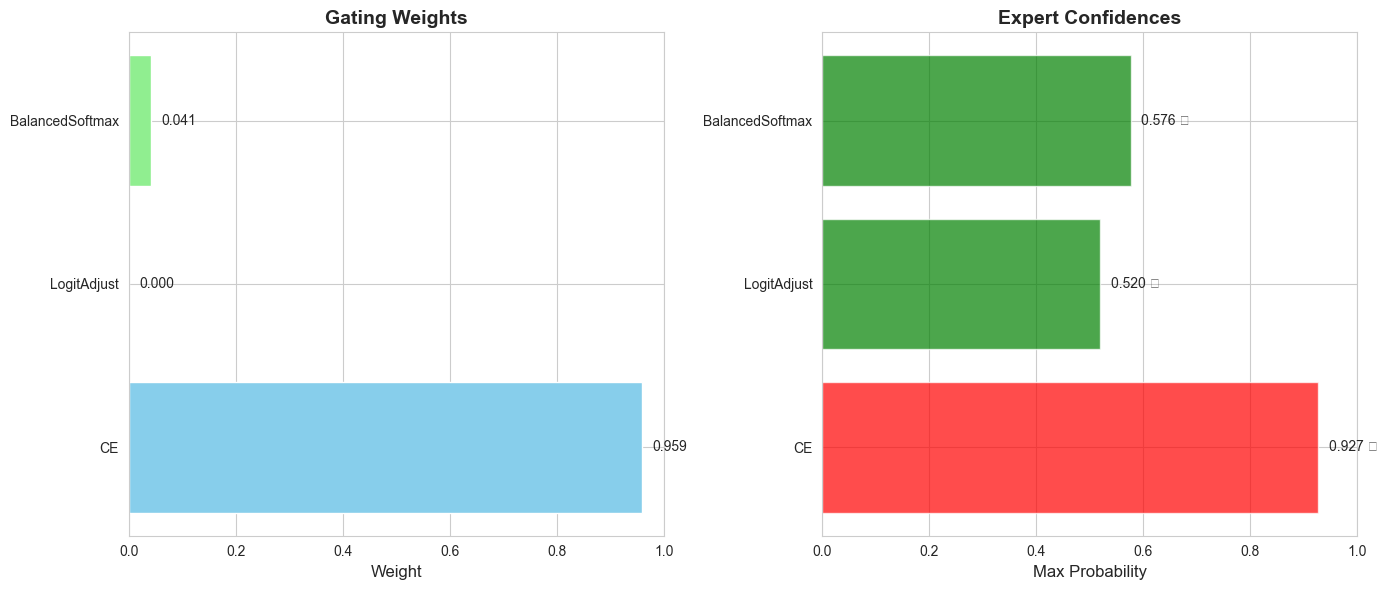

In [15]:
# Expert Contributions
expert_names = EXPERT_DISPLAY_NAMES
expert_preds = our_result['expert_predictions']
gating_weights = our_result['gating_weights']
expert_probs = our_result['expert_probs']

print("📊 Expert Contributions:")
for i, (name, pred, weight, probs) in enumerate(zip(expert_names, expert_preds, gating_weights, expert_probs)):
    correct = '✅' if pred == true_label else '❌'
    max_prob = np.max(probs)
    print(f"   {name}:")
    print(f"      Prediction: {pred} ({class_names[pred]}) {correct}")
    print(f"      Gating Weight: {weight:.4f}")
    print(f"      Max Probability: {max_prob:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gating weights
ax1 = axes[0]
ax1.barh(expert_names, gating_weights, color=['skyblue', 'lightcoral', 'lightgreen'])
ax1.set_xlabel('Weight', fontsize=12)
ax1.set_title('Gating Weights', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1])
for i, (name, weight) in enumerate(zip(expert_names, gating_weights)):
    ax1.text(weight + 0.02, i, f'{weight:.3f}', va='center', fontsize=10)

# Expert confidences
ax2 = axes[1]
expert_confidences = [np.max(probs) for probs in expert_probs]
colors = ['green' if pred == true_label else 'red' for pred in expert_preds]
ax2.barh(expert_names, expert_confidences, color=colors, alpha=0.7)
ax2.set_xlabel('Max Probability', fontsize=12)
ax2.set_title('Expert Confidences', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1])
for i, (name, conf, pred) in enumerate(zip(expert_names, expert_confidences, expert_preds)):
    status = '✅' if pred == true_label else '❌'
    ax2.text(conf + 0.02, i, f'{conf:.3f} {status}', va='center', fontsize=10)

plt.tight_layout()
plt.show()